In [110]:
import pandas as pd
import time
import requests
from io import StringIO
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [2]:
colnames = ['smiles', 'dat', 'id']
df_act = pd.read_csv('pygm_1c8k_actives.ism', sep=' ', names=colnames)
df_act.head()

,smiles,dat,id
0,c1ccc2cc(c(cc2c1)NC(=O)c3cc(ccn3)N(=O)=O)Oc4cc...,220668,CHEMBL134802
1,CC1=C(C(C(=C(N1Cc2ccc(cc2)Cl)C(=O)O)C(=O)O)c3c...,189331,CHEMBL115651
2,CCN1C(=C(C(C(=C1C(=O)O)C(=O)O)c2ccccc2Cl)C(=O)...,188996,CHEMBL113736
3,c1cc(c(c(c1)F)NC(=O)c2cc(ccn2)N(=O)=O)Oc3ccc(c...,219845,CHEMBL133911
4,CC1=C(C(C(=C(N1Cc2cccc(c2)N(=O)=O)C(=O)O)C(=O)...,189034,CHEMBL423509


In [4]:
len(df_act)

77

In [7]:
# similarity search against pubchem
# count number of times compound is returned as hit

smiles_act = df_act['smiles']
prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'

cids_hit = {}

for idx, smile in enumerate(smiles_act):
    
    data = {'smiles' : smile}
    
    url = prolog + '/compound/fastsimilarity_2d/smiles/cids/txt'
    res = requests.post(url, data=data)
    
    if res.status_code == 200:
        cids = res.text.split()
        cids = map(int, cids)
        
    else:
        print('error at {} : {} {}'.format(idx, df_act.loc[idx, 'id'], smile))
        print(res.status_code)
        print(res.content)
        
    for cid in cids:
        cids_hit[cid] = cids_hit.get(cid, 0) + 1
        
    time.sleep(0.2)
    

In [8]:
len(cids_hit)

25025

In [13]:
# top 10 hits
sorted_by_freq = sorted(cids_hit.items(), key = lambda x: x[1], reverse=True)

for i, (k, v)  in enumerate(sorted_by_freq):
    if i == 10:
        break
    print(v, k)

16 44354348
15 44354370
15 44354349
15 44354322
13 44357907
12 44354455
12 44354454
12 44354362
12 44354301
12 44354350


In [15]:
# exlude the query compound from the hits

cids_query = {}

for idx, smile in enumerate(smiles_act):
    
    data = {'smiles' : smile}
    url = prolog + '/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity'
    res = requests.post(url, data=data)
    
    if res.status_code == 200:
        cids = res.text.split()
        cids = map(int, cids)
        
    else:
        print('error at {} : {} {}'.format(idx, df_act.loc[idx, 'id'], smile))
        print(res.status_code)
        print(res.content)
        
    for cid in cids:
        cids_query[cid] = cids_query.get(cid, 0) + 1
        
    time.sleep(0.2)

In [16]:
len(cids_query.keys())

134

In [17]:
# remove query compound
for cid in cids_query.keys():
    cids_hit.pop(cid, None)

In [18]:
len(cids_hit)

24891

In [19]:
sorted_by_freq = sorted(cids_hit.items(), key = lambda x: x[1], reverse=True)
for i, (k, v) in enumerate(sorted_by_freq):
    
    if i == 10:
        break
    
    print(v, k)

12 11779854
11 118078858
11 141135915
11 17600716
11 45369696
11 51808718
11 53013349
11 93077064
11 93077065
10 44358150


In [22]:
# filter out non-drug-like compounds

chunk_size = 100

if len(cids_hit) % chunk_size == 0:
    num_chunks = len(cids_hit) // chunk_size
else:
    num_chunks = len(cids_hit) // chunk_size + 1
    
cids_list = list(cids_hit.keys())

print('# number of chunks:', num_chunks)

csv = ''

for i in range(num_chunks):
    print(i, end=' ')
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i+1)
    
    cids_str = ','.join(map(str, cids_list[idx1:idx2]))
    url = prolog + f'/compound/cid/{cids_str}/property/hbonddonorcount,hbondacceptorcount,molecularweight,xlogp,canonicalsmiles,isomericsmiles/csv'
    res = requests.get(url)
    
    if i == 0:
        csv = res.text
    else:
        csv = csv + '\n'.join(res.text.split()[1:]) + '\n'
        
    time.sleep(0.2)

# number of chunks: 249
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 

In [24]:
csv_file = StringIO(csv)
df_raw = pd.read_csv(csv_file, sep=',')
df_raw.shape

(24891, 7)

In [25]:
df_raw.head()

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
0,1731763,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=C(C=C2)Cl)C(=O)OCC...
1,21795259,0,5,454.0,5.5,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...,CCOC(=O)C1=C(N(C(=C(C1C2=CC=CC=C2Cl)C(=O)OCC)C...
2,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
3,70157737,2,4,436.9,4.6,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
4,70074958,2,6,448.9,3.9,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C(=O)N...,CC1=C([C@@H](C(=C(N1)C)C(=O)OC)C2=CC=CC=C2Cl)C...


In [26]:
# chekc na
df_raw.isna().sum()

CID                     0
HBondDonorCount         0
HBondAcceptorCount      0
MolecularWeight         0
XLogP                 716
CanonicalSMILES         0
IsomericSMILES          0
dtype: int64

In [27]:
len(df_raw)

24891

In [46]:
df_freq = pd.DataFrame.from_dict(cids_hit, orient='index').reset_index()
df_freq.columns = ['CID', 'hitfreq']
df_freq.head()

,CID,hitfreq
0,1731763,2
1,21795259,4
2,9910160,3
3,70157737,3
4,70074958,3


In [47]:
df_freq.sort_values(by=['hitfreq', 'CID'], ascending=False).head(10)

,CID,hitfreq
1035,11779854,12
1232,141135915,11
385,118078858,11
2829,93077065,11
2828,93077064,11
2182,53013349,11
2141,51808718,11
1909,45369696,11
1671,17600716,11
1123,145780788,10


In [50]:
df = df_raw.join(df_freq.set_index('CID'), on='CID')
df.shape

(24891, 8)

In [51]:
df.sort_values(by=['hitfreq', 'CID'], ascending=False).head(10)

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,hitfreq
1035,11779854,3,2,305.3,2.6,C1C(C(=O)NC2=CC=CC=C21)NC(=O)C3=CC4=CC=CC=C4N3,C1C(C(=O)NC2=CC=CC=C21)NC(=O)C3=CC4=CC=CC=C4N3,12
1232,141135915,1,1,290.4,4.2,CC1CCC2=CC=CC=C2N1C(=O)C3=CC4=CC=CC=C4N3,CC1CCC2=CC=CC=C2N1C(=O)C3=CC4=CC=CC=C4N3,11
385,118078858,1,2,333.4,3.0,CC1CN(C2=CC=CC=C2N1C(=O)C)C(=O)C3=CC4=CC=CC=C4N3,C[C@H]1CN(C2=CC=CC=C2N1C(=O)C)C(=O)C3=CC4=CC=C...,11
2829,93077065,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)[C@@H](C3=CC=CC=C3)NC(...,11
2828,93077064,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)[C@H](C3=CC=CC=C3)NC(=...,11
2182,53013349,2,2,409.5,4.8,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,C1CC2=CC=CC=C2N(C1)C(=O)C(C3=CC=CC=C3)NC(=O)C4...,11
2141,51808718,2,3,390.5,2.9,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,C[C@H](C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC...,11
1909,45369696,2,3,390.5,2.9,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,11
1671,17600716,2,3,390.5,2.9,CC(C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=CC4=CC...,C[C@@H](C(=O)N1CCN(CC1)CC2=CC=CC=C2)NC(=O)C3=C...,11
1123,145780788,1,2,437.5,5.3,CCC(=O)N(C1CC(N(C2=CC=CC=C12)C(=O)C3=CC4=CC=CC...,CCC(=O)N([C@@H]1C[C@@H](N(C2=CC=CC=C12)C(=O)C3...,10


In [52]:
# identify compounds satisfying lipinskys rule of 5

df = df[ (df['HBondDonorCount'] <= 5) &
         (df['HBondAcceptorCount'] <= 10) &
         (df['MolecularWeight'] <= 500) &
         (df['XLogP'] < 5)]

In [53]:
len(df)

21427

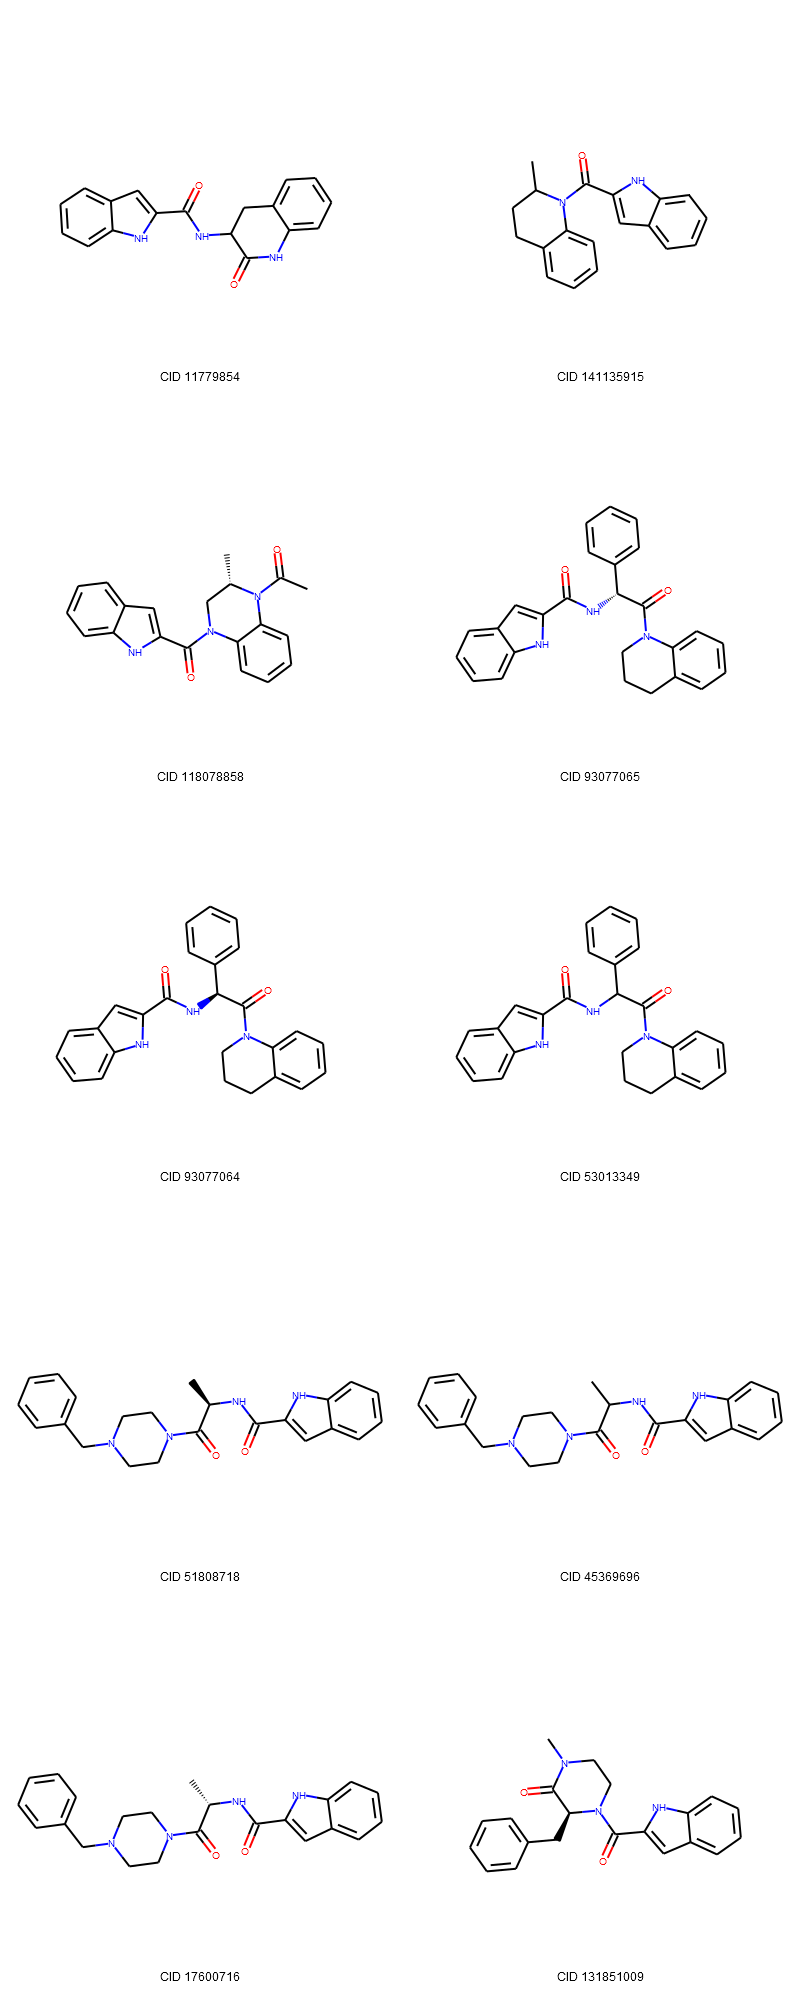

In [62]:
# draw structures of top 10 compounds

cids_top = df.sort_values(by=['hitfreq', 'CID'], ascending=False).head(10)['CID']

mols = []
for cid in cids_top:
    
    smile = df.query("CID == @cid")['IsomericSMILES'].item()
    
    mol = Chem.MolFromSmiles(smile)
    Chem.FindPotentialStereoBonds(mol)
    mols.append(mol)
    
legends = ['CID {}'.format(x) for x in cids_top]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=legends)
display(img)

In [63]:
# chemicals with same connectivity but different sterochemistry will have same canonical smiles
# select canonical smiles to reduce number of compounds to screen

In [64]:
len(df)

21427

In [65]:
len(df['CanonicalSMILES'].unique())

17086

In [71]:
canonical_smiles = df['CanonicalSMILES'].unique()
df.query('CanonicalSMILES == @canonical_smiles[0]')

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,hitfreq
2,9910160,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3
22,70155849,3,4,422.9,4.4,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...,3


In [75]:
df.query('CanonicalSMILES == @canonical_smiles[1]')['IsomericSMILES']

3    CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
6    CC1=C(C(C(=C(N1)C)C(=O)O)C2=CC(=CC=C2)Cl)C(=O)...
Name: IsomericSMILES, dtype: object

In [80]:
# unique compounds in terms of canonical smiles

idx_to_include = []
for smile in canonical_smiles:
    idx = df.query("CanonicalSMILES == @smile").index[0]
    idx_to_include.append(idx)

In [81]:
len(idx_to_include)

17086

In [82]:
df['include'] = 0
df['include'].sum()

0

In [83]:
df.loc[idx_to_include, 'include'] = 1
df['include'].sum()

17086

In [84]:
df[['CID', 'include']].head(10)

,CID,include
2,9910160,1
3,70157737,1
4,70074958,1
5,70073800,0
6,18318317,0
7,18318313,1
9,18318274,1
10,18318270,1
11,15838576,0
12,15838575,1


In [85]:
# draw top 10 unique compounds

cids_top = df.query('include == 1').sort_values(by=['hitfreq', 'CID'], ascending=False).head(10)['CID']

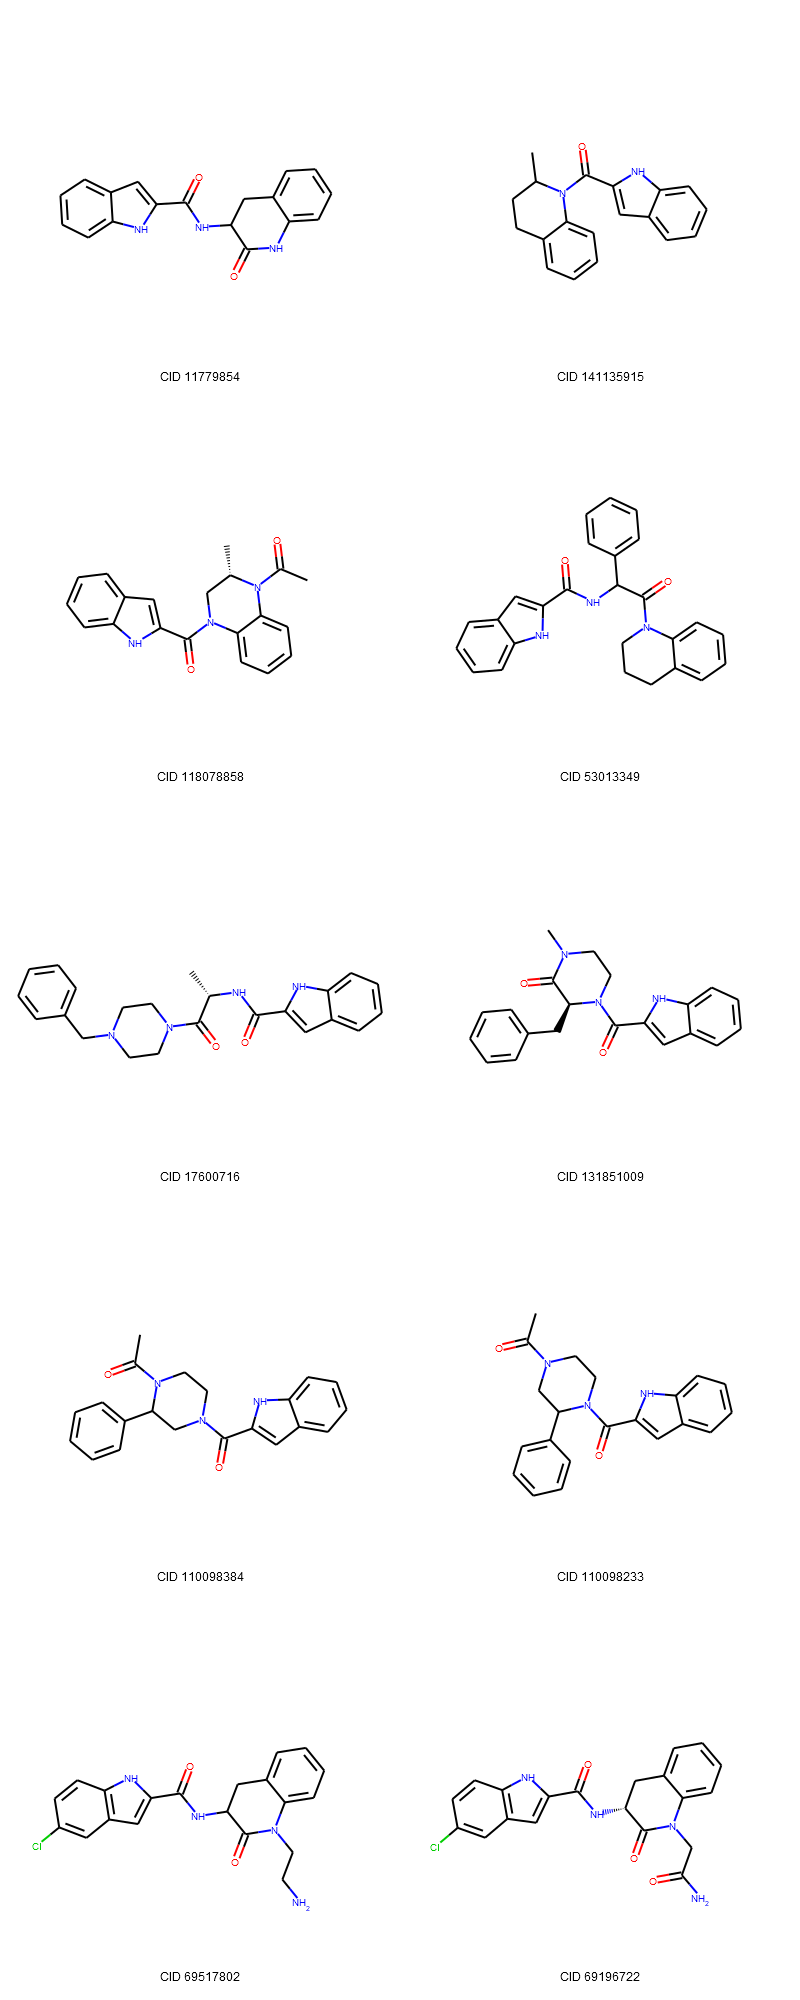

In [87]:
mols = []
for cid in cids_top:
    smiles = df.query('CID == @cid')['IsomericSMILES'].item()
    mol = Chem.MolFromSmiles(smiles)
    Chem.FindPotentialStereoBonds(mol)
    mols.append(mol)

legends = ['CID {}'.format(x) for x in cids_top]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=legends)
display(img)

In [89]:
# save top 3

for idx, cid in enumerate(cids_top):
    
    if idx == 3:
        break
        
    smiles = df.query('CID == @cid')['IsomericSMILES'].item()
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    
    filename = 'pygm_lig_{}_{}.mol'.format(idx, cid)
    Chem.MolToMolFile(mol, filename)

In [107]:
# dud-e target cyclooxigenase-2 pgh2
# load data
# print number of row
# print first 5 rows

def ex_1():
    
    # download pgh2
    url = 'http://dude.docking.org/targets/pgh2/actives_final.ism'
    r = requests.get(url)
    
    df = pd.read_csv(StringIO(r.text), delim_whitespace=True, names=['smiles', 'dat', 'id'])
    
    return df

In [108]:
df = ex_1()
print(df.shape)
df.head()

(435, 3)


,smiles,dat,id
0,OC(=O)CCCC[C@@H]1CCSS1,224463,CHEMBL134342
1,COc4ccc(c2c(c1ccc(S(N)(=O)=O)cc1)[nH]c3ccccc23...,510082,CHEMBL499068
2,Fc5ccc(c3[nH]c(c1ccc(F)cc1)c4C2CCC(C2)c34)cc5,235438,CHEMBL143776
3,Fc5ccc(c3[nH]c(c1ccc(F)cc1)c4C2CCC(CC2)c34)cc5,234337,CHEMBL140167
4,CS(=O)(=O)c3ccc(c2cc(C(F)(F)F)nc(NCc1ccccc1)n2...,561172,CHEMBL551829


In [146]:
# similarity search using each isomeric smiles 

def ex_2():
    
    all_cids = []
    for i, smiles in enumerate(tqdm(df['smiles'])):

        prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
        url = prolog + '/compound/fastsimilarity_2d/smiles/cids/txt'
        data = {'smiles' : smiles}
        
        r = requests.post(url, data=data)
    
        if r.status_code == 200:
            cids = r.text.split()
            all_cids.extend(cids)
            
        else:
            print('error at {}: {} {}'.format(i, df.loc[i, 'id'], smiles))
            print(r.status_code)
            print(r.content)
        
        time.sleep(0.2)
        
    all_cids = Counter(all_cids)
    
    return all_cids

In [148]:
cids_hit = ex_2()

error at 302: CHEMBL287336 CCC(O)c2nc1c(C(F)(F)F)cccc1c(O)c2C(=O)Nc3nccs3
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Search returned no hits\nDetail: hits: 0 percent completion: 100 ; Average individual thread time (msec): 1118 ; Total parallel thread time (msec): 1256\n'
error at 312: CHEMBL62101 Fc5ccc(NC(=O)C2C(=O)n3c1ccccc1sc4cccc2c34)c(F)c5
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Search returned no hits\nDetail: hits: 0 percent completion: 100 ; Average individual thread time (msec): 1105 ; Total parallel thread time (msec): 1228\n'
error at 326: CHEMBL414437 Cc3nn(c1ccc(S(N)(=O)=O)cc1)c4c2cc(N(=O)=O)ccc2nc(O)c34
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Search returned no hits\nDetail: hits: 0 percent completion: 100 ; Average individual thread time (msec): 1084 ; Total parallel thread time (msec): 1203\n'


In [149]:
len(cids_hit)

83473

In [152]:
# get cids of query compounds through identity search
# remove from hit list

def ex_3(cids_hit):
    
    # smiles to cid
    all_cids = []
    for i, smiles in enumerate(tqdm(df['smiles'])):
        data = {'smiles' : smiles} 
        url = prolog + '/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity'
        r = requests.post(url, data=data)
        
        if r.status_code == 200:
            cids = r.text.split()
            all_cids.extend(cids)
            
        else:
            print('error at {}: {} {}'.format(i, df.loc[i, 'id'], smile))
            print(r.status_code)
            print(r.content)
            
        time.sleep(0.1)
        
    all_cids = Counter(all_cids)
    print(len(all_cids))
    
    # remove from hit list
    for cid in all_cids.keys():
        cids_hit.pop(cid, None)
    
    return cids_hit
            

In [153]:
cids_hit = ex_3(cids_hit)
print(len(cids_hit))

error at 131: CHEMBL61422 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
error at 229: CHEMBL292324 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
error at 312: CHEMBL62101 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
error at 314: CHEMBL293617 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
error at 356: CHEMBL276850 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
error at 397: CHEMBL606555 CCCOC1=C(C=C(C=C1)C(=O)O)NC(=O)C2=C(C(=CC=C2)[N+](=O)[O-])C
404
b'Status: 404\nCode: PUGREST.NotFoun

In [182]:
# cids to properties
# to df

def ex_4(cids_hit):
    
    chunk_size = 100
    
    # get list of keys
    cids_hit =[k for k, v in cids_hit.items()]
    
    if len(cids_hit) % chunk_size == 0:
        num_chunks = len(cids_hit) // chunk_size
    else:
        num_chunks = len(cids_hit) // chunk_size + 1
        
    csv = ''
    for i in tqdm(range(num_chunks)):
        
        idx1 = chunk_size * i
        idx2 = chunk_size * (i+1)
        
        cids_str = ','.join(cids_hit[idx1:idx2])
        url = prolog + f'/compound/cid/{cids_str}/property/hbonddonorcount,hbondacceptorcount,molecularweight,xlogp,canonicalsmiles,isomericsmiles/csv'
        r = requests.get(url)
        
        csv += r.text
        
        time.sleep(0.1)
        
    df = pd.read_csv(StringIO(csv))
    
    return df

In [183]:
df_raw = ex_4(cids_hit)

In [184]:
df_raw.head()

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
0,421,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)CC(CCS)S
1,9834298,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)C[C@H](CCS)S
2,1549144,0,4,205.300000,2.3,C1CSSC1CCCCC(=O)[O-],C1CSS[C@@H]1CCCCC(=O)[O-]
3,449141,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)C[C@@H](CCS)S
4,23665026,0,4,228.300000,NaN,C1CSSC1CCCCC(=O)[O-].[Na+],C1CSSC1CCCCC(=O)[O-].[Na+]


In [187]:
# merge cids_hit and df_raw

def ex_5(cids_hit, df_raw):
    
    df_freq = pd.DataFrame.from_dict(cids_hit, orient='index').reset_index()
    df_freq.columns = ['CID', 'count']
    
    df = df_freq.merge(df_raw, on='CID')
    
    return df

In [188]:
df = ex_5(cids_hit, df_raw)
print(df.shape)

(82636, 8)


In [189]:
df.head()

,CID,count,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
0,421,1,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)CC(CCS)S
1,9834298,1,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)C[C@H](CCS)S
2,1549144,1,0,4,205.300000,2.3,C1CSSC1CCCCC(=O)[O-],C1CSS[C@@H]1CCCCC(=O)[O-]
3,449141,1,3,4,208.300000,1.8,C(CCC(=O)O)CC(CCS)S,C(CCC(=O)O)C[C@@H](CCS)S
4,23665026,1,0,4,228.300000,NaN,C1CSSC1CCCCC(=O)[O-].[Na+],C1CSSC1CCCCC(=O)[O-].[Na+]


In [192]:
# remove compounds that violoate congreves rule of 3

def ex_6(df):
    
    df = df.apply(pd.to_numeric, errors='ignore')
    
    df = df[(df['MolecularWeight'] < 300) &
            (df['HBondDonorCount'] <= 3) &
            (df['HBondAcceptorCount'] <= 3) &
            (df['XLogP'] <= 3)]
    
    return df

In [193]:
df = ex_6(df)

In [195]:
print(df.shape)
df.head()

(9679, 8)


,CID,count,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
46,22065545,1,1,3,174.26,1.6,C(CCCC(=O)O)CCC=S,C(CCCC(=O)O)CCC=S
52,145103858,1,2,3,207.30,1.7,C1CS[SH+]C1CCCCC(=O)O,C1CS[SH+][C@@H]1CCCCC(=O)O
103,131858174,1,1,2,206.30,1.8,C(CCC(=O)O)CC(CC[S])[S],C(CCC(=O)O)CC(CC[S])[S]
1222,12248413,1,0,3,276.40,2.4,CC1=CC=C(C=C1)S(=O)(=O)CC2=CC=C(C=C2)OC,CC1=CC=C(C=C1)S(=O)(=O)CC2=CC=C(C=C2)OC
1223,10999865,1,0,3,262.33,2.0,COC1=CC=C(C=C1)CS(=O)(=O)C2=CC=CC=C2,COC1=CC=C(C=C1)CS(=O)(=O)C2=CC=CC=C2


In [196]:
# drop duplicate canonical smiles

def ex_7(df):
    
    df = df.drop_duplicates('CanonicalSMILES')
    print(df.shape)
    
    return df

In [198]:
df = ex_7(df)

(8381, 8)


In [199]:
df.head()

,CID,count,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
46,22065545,1,1,3,174.26,1.6,C(CCCC(=O)O)CCC=S,C(CCCC(=O)O)CCC=S
52,145103858,1,2,3,207.30,1.7,C1CS[SH+]C1CCCCC(=O)O,C1CS[SH+][C@@H]1CCCCC(=O)O
103,131858174,1,1,2,206.30,1.8,C(CCC(=O)O)CC(CC[S])[S],C(CCC(=O)O)CC(CC[S])[S]
1222,12248413,1,0,3,276.40,2.4,CC1=CC=C(C=C1)S(=O)(=O)CC2=CC=C(C=C2)OC,CC1=CC=C(C=C1)S(=O)(=O)CC2=CC=C(C=C2)OC
1223,10999865,1,0,3,262.33,2.0,COC1=CC=C(C=C1)CS(=O)(=O)C2=CC=CC=C2,COC1=CC=C(C=C1)CS(=O)(=O)C2=CC=CC=C2


In [223]:
# sort by count (descending) and cid (ascending)
# pick top 10
# print cid, isomeric smile, count
# draw structure from isomeric smile

def ex_8(df):
    
    # select top counts
    df_sort = df.sort_values(by=['count', 'CID'], ascending=[False, True]).head(10)
    
    # print
    #print(df_sort[['CID', 'IsomericSMILES', 'count']])
    
    # draw
    mols = []
    for smile in df_sort['IsomericSMILES']:
        mol = Chem.MolFromSmiles(smile)
        Chem.FindPotentialStereoBonds(mol)
        mols.append(mol)
    
    legends = ['CID {}'.format(x) for x in df_sort['CID']]
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=legends)
    display(img)
    

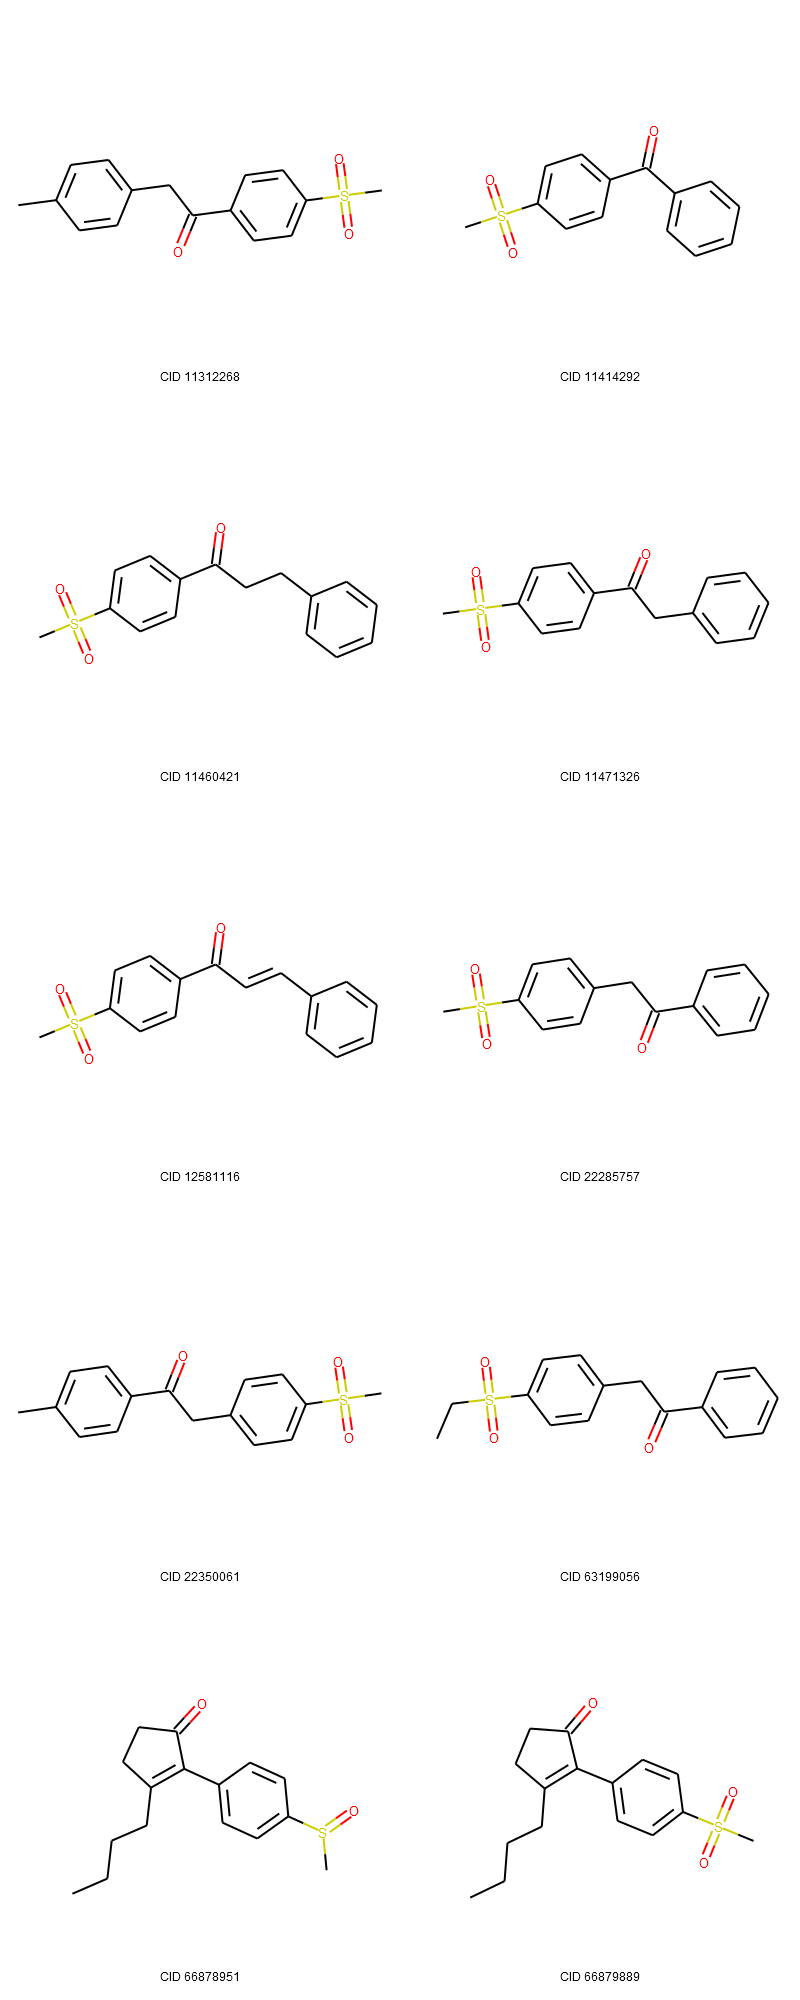

In [224]:
ex_8(df)